# Parameter Identification Technique (PIT) on a linear VMM model

# Purpose
Show the general workflow by applying PIT regression on a very simple model

# Methodology
* Load time series from a ZigZag test
* Determine yaw rate and acceleration (compare with accelerometers from test).
* Find the best parameter values in the Nomoto model using OLS linear regression.

# Setup

In [129]:
# %load imports.py
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  ## (To fix autocomplete)

## External packages:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)

import numpy as np
import os
import matplotlib.pyplot as plt
#if os.name == 'nt':
#    plt.style.use('presentation.mplstyle')  # Windows

import plotly.express as px 
import plotly.graph_objects as go

import seaborn as sns
import sympy as sp
from sympy.physics.mechanics import (dynamicsymbols, ReferenceFrame,
                                      Particle, Point)
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex
from src.substitute_dynamic_symbols import run, lambdify

import pyro

import sklearn
import pykalman
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm

from scipy.integrate import solve_ivp

## Local packages:
from src.data import mdl
from src.models import linear_vmm
import src.linear_vmm_equations as eq
from src.symbols import *
import src.symbols as symbols
from src.models import regression


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load test

In [130]:
df_runs = mdl.runs()

In [295]:
#id=22773
#id=22616
#id=22774
id=22770


df, units, meta_data = mdl.load(id=id, dir_path='../data/processed/kalman')
df.index = df.index.total_seconds()
df = df.iloc[0:-100].copy()
df.index-=df.index[0]
df.sort_index(inplace=True)

In [296]:
meta_data['rho']=1000
meta_data['mass'] = meta_data['Volume']*meta_data['rho']
meta_data.dropna()

A0                                                               0.722775
KXX                                                              0.331311
KZZ                                                              1.253641
TA                                                               0.206311
TF                                                               0.206311
Volume                                                           0.441027
angle1                                                               10.0
angle2                                                               10.0
beam                                                             0.946602
comment                                                        ZZ 10/10PS
date                                                           2020-09-24
facility                                                              MDL
file_path_hdf5          \\sspa.local\lab\MeasuredataMDL\40199079\005\0...
gm                                    

In [258]:
df.head()

,Arr/Ind/Arr,Arr/Ind/Fri,Fan/Aft/Angle,Fan/Aft/AngleOrder,Fan/Aft/Fx,Fan/Aft/FxOrder,Fan/Aft/Rpm,Fan/Aft/RpmOrder,Fan/ForceFactor,Fan/Fore/Angle,Fan/Fore/AngleOrder,Fan/Fore/Fx,Fan/Fore/FxOrder,Fan/Fore/Rpm,Fan/Fore/RpmOrder,Hull/Acc/X1,Hull/Acc/Y1,Hull/Acc/Y2,Hull/Acc/Z1,Hull/Acc/Z2,Hull/Acc/Z3,Prop/PS/Rpm,Prop/PS/Thrust,Prop/PS/Torque,Prop/SB/Rpm,Prop/SB/Thrust,Prop/SB/Torque,delta,Rudder/MaxAngle,Rudder/Rate,Wind/Course,Wind/CourseTreshold,Wind/GWA,lab/WaveHeight,roll,pitch,psi,x0,y0,z0,x01d_gradient,y01d_gradient,z01d_gradient,z02d_gradient,psi1d_gradient,x0_filtered,x01d,x02d,y0_filtered,y01d,y02d,psi_filtered,psi1d,psi2d,u,v,w,u1d,v1d,w1d,r,r1d,beta
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,0.0,1.0,2.146755,0.000930,0.244419,0.0,-0.520477,10.131507,1.0,2.146755,-0.024623,0.122683,0.0,2.144633,11.329219,-0.000651,-0.009621,-0.007185,-0.002344,0.006963,0.008156,9.597722,5.567396,-0.113822,9.546612,5.328476,0.104278,-0.000007,0.645772,14.89,-0.005037,0.1,0.0,0.000025,0.000927,0.000325,-0.000873,7.611185,-0.001594,0.002499,1.020600,-0.003508,-0.022730,1.867924,0.017441,7.630116,0.932272,0.000005,-0.001617,0.000065,-6.810068e-07,-0.000821,0.000001,-0.000004,0.932272,0.000830,-0.022730,0.000005,-6.766628e-07,1.867924,0.000001,-0.000004,-0.000890
0.010007,0.0,1.0,2.146755,0.000832,0.121932,0.0,-0.288911,10.131507,1.0,2.146755,-0.022034,0.126699,0.0,1.025401,11.329219,0.012245,-0.012845,-0.014928,-0.012007,0.019213,0.003000,9.572657,5.679435,-0.110951,9.558256,5.397689,0.106811,-0.000007,0.645772,14.89,-0.004507,0.1,0.0,0.000025,0.000972,-0.000254,-0.000698,7.621398,-0.001629,0.002271,0.508139,0.000864,-0.004038,1.308212,0.013081,7.625826,0.921355,-0.002257,-0.001613,0.000114,-1.514633e-05,-0.000735,-0.000025,-0.000024,0.921354,0.000791,-0.004038,-0.002257,-1.680414e-05,1.308212,-0.000025,-0.000024,-0.000859
0.020011,0.0,1.0,2.146755,0.000736,-0.120384,0.0,0.000545,10.131507,1.0,2.146755,-0.019471,0.025530,0.0,1.913068,11.329219,-0.001296,-0.012200,-0.029125,0.002810,0.021792,0.002356,9.514150,5.728091,-0.107321,9.562515,5.484805,0.109010,0.000000,0.645772,14.89,-0.003983,0.1,0.0,0.000025,0.000915,0.000341,-0.000611,7.621356,-0.001577,0.002418,0.952405,0.001934,0.003452,0.258792,-0.008754,7.627892,0.921396,-0.003307,-0.001587,0.000145,-2.490043e-05,-0.000702,-0.000131,-0.000054,0.921396,0.000792,0.003452,-0.003307,-2.722338e-05,0.258792,-0.000131,-0.000054,-0.000860
0.030001,0.0,1.0,2.146755,0.000638,-0.310377,0.0,0.521567,10.131507,1.0,2.146755,-0.016901,-0.089957,0.0,0.639459,11.329219,0.005152,-0.012845,-0.016219,-0.005565,0.007608,-0.001511,9.541821,5.700100,-0.104350,9.587783,5.548451,0.110168,0.000000,0.645772,14.89,-0.003457,0.1,0.0,0.000025,0.000945,-0.000327,-0.000873,7.640413,-0.001590,0.002341,1.483970,0.002393,0.001150,-0.262092,-0.008748,7.639433,0.923933,-0.002592,-0.001575,0.000151,-3.795793e-05,-0.000805,-0.000191,-0.000113,0.923932,0.000895,0.001150,-0.002592,-4.004497e-05,-0.262092,-0.000191,-0.000113,-0.000969
0.040001,0.0,1.0,2.146755,0.000549,-0.303348,0.0,0.463676,10.131507,1.0,2.146755,-0.014543,-0.130523,0.0,-0.749933,11.329219,0.007087,-0.017357,-0.023318,-0.001700,0.017924,-0.002155,9.514368,5.613694,-0.103258,9.562679,5.586684,0.110073,0.000000,0.645772,14.89,-0.002975,0.1,0.0,0.000025,0.000929,0.000426,-0.000785,7.651012,-0.001529,0.002441,0.931076,0.003854,-0.001788,0.240757,-0.000002,7.649572,0.924786,-0.002156,-0.001540,0.000128,-4.577976e-05,-0.000809,-0.000182,-0.000150,0.924785,0.000876,-0.001788,-0.002156,-4.752416e-05,0.240757,-0.000182,-0.000150,-0.000948


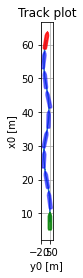

In [259]:
from src.visualization.plot import track_plot
fig,ax=plt.subplots()
#fig.set_size_inches(10,10)
track_plot(df=df, lpp=meta_data.lpp, x_dataset='x0', y_dataset='y0',  psi_dataset='psi', beam=meta_data.beam, ax=ax);

## Yaw rate

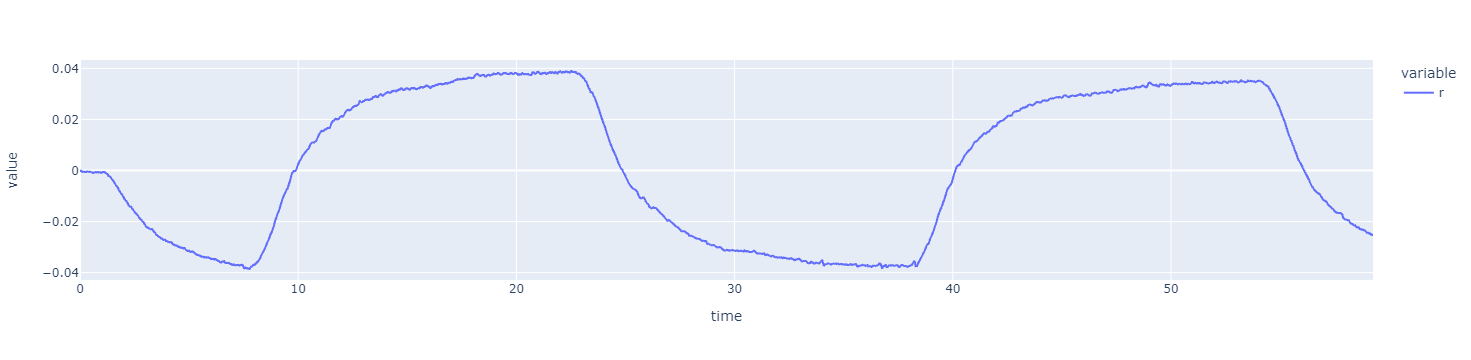

In [260]:
px.line(data_frame=df, y=['r'], width=1400, height=300,)

# Linear VMM

## N

In [261]:
Math(vlatex(eq.N_eq))

<IPython.core.display.Math object>

In [262]:
N_eq = eq.N_eq.copy()
N_eq = N_eq.subs([
    (x_G,0),  # Assuming or moving to CG=0
    #(I_z,1),  # Removing inertia
    #(eq.p.Nrdot,0),  # Removing added mass
    (eq.p.Nvdot,0),  # Removing added mass
    (eq.p.Nudot,0),  # Removing added mass
    
])  

solution = sp.solve(N_eq,r.diff())[0]
N_eq = sp.Eq(r.diff(), solution*(I_z-eq.p.Nrdot))  # Putting r1d on the LHS

In [263]:
#Math(vlatex(N_eq))

In [264]:
diff_eq_N = regression.DiffEqToMatrix(ode=N_eq, label=r.diff(), base_features=[delta,u,v,r])

In [265]:
Math(vlatex(diff_eq_N.acceleration_equation))

<IPython.core.display.Math object>

$ y = X \cdot \beta + \epsilon $

In [266]:
Math(vlatex(diff_eq_N.acceleration_equation_x))

<IPython.core.display.Math object>

In [267]:
Math(vlatex(diff_eq_N.eq_y))

<IPython.core.display.Math object>

In [268]:
diff_eq_N.eq_beta

Eq(beta, Matrix([
[N_{\delta}],
[     N_{r}],
[     N_{u}],
[     N_{v}]]))

In [269]:
Math(vlatex(diff_eq_N.eq_X))

<IPython.core.display.Math object>

In [270]:
diff_eq_N.X_lambda

<function _lambdifygenerated(delta, r, u, v)>

In [271]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
def show_pred(X,y,results, label):
    
    display(results.summary())
    
    X_ = X
    y_ = y
    y_pred = results.predict(X_)
    
    prstd, iv_l, iv_u = wls_prediction_std(results, exog=X_, alpha=0.05)
    #iv_l*=-1 
    #iv_u*=-1
    
    fig,ax=plt.subplots()
    ax.plot(X_.index,y_, label='Numerical gradient from model test')
    ax.plot(X_.index,y_pred, '--', label='OLS')
    ax.set_ylabel(label)
    
    ax.fill_between(X_.index, y1=iv_l, y2=iv_u, zorder=-10, color='grey', alpha=0.5, label=r'5\% confidence')
    ax.legend();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    r1d   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                          2.639e+04
Date:                Tue, 29 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:36:19   Log-Likelihood:                          29793.
No. Observations:                5927   AIC:                                 -5.958e+04
Df Residuals:                    5923   BIC:                                 -5.955e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ndelta        -0.0642      0.000   -130.818      0.000      -0.065      -0.063
Nr            -0.2182      0.005    -44.541      0.000      -0.228      -0.209
Nu         -1.668e-05   2.35e-05     -0.710      0.478   -6.27e-05    2.94e-05
Nv             0.0486      0.001     39.318      0.000       0.046       0.051
==============================================================================
Omnibus:                      240.243   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              733.490
Skew:                          -0.090   Prob(JB):                    5.30e-160
Kurtosis:                       4.714   Cond. No.                         223.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

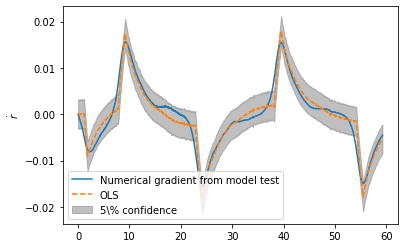

In [272]:
X = diff_eq_N.calculate_features(data=df)
y = diff_eq_N.calculate_label(y=df['r1d'])

model_N = sm.OLS(y,X)
results_N = model_N.fit()

show_pred(X=X,y=y,results=results_N, label=r'$\dot{r}$')

## Y

In [273]:
Y_eq = eq.Y_eq.copy()
Y_eq = Y_eq.subs([
    #(eq.p.Yvdot,1),  # Removing added mass
    (eq.p.Yudot,0),  # Removing added mass
    (eq.p.Yrdot,0),  # Removing added mass  
    (x_G,0),  
    
])  
solution = sp.solve(Y_eq,v.diff())[0]
solution = solution*(-eq.p.Yvdot+m)
solution = solution + U*m*r# (adding u*m*r to the measurement fy instead)  
Y_eq = sp.simplify(sp.Eq(v.diff(), solution))  # Putting r1d on the LHS

In [274]:
Math(vlatex(Y_eq))

<IPython.core.display.Math object>

In [275]:
diff_eq_Y = regression.DiffEqToMatrix(ode=Y_eq, label=v.diff(), base_features=[delta,u,v,r])

In [276]:
diff_eq_Y.eq_beta

Eq(beta, Matrix([
[Y_{\delta}],
[     Y_{r}],
[     Y_{u}],
[     Y_{v}]]))

In [277]:
diff_eq_Y.acceleration_equation_x

Eq(y, Y_{\delta}*x_1 + Y_{r}*x_2 + Y_{u}*x_3 + Y_{v}*x_4)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    v1d   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          5.174e+05
Date:                Tue, 29 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:36:24   Log-Likelihood:                          31607.
No. Observations:                5927   AIC:                                 -6.321e+04
Df Residuals:                    5923   BIC:                                 -6.318e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Ydelta         0.0493      0.000    136.290      0.000       0.049       0.050
Yr             0.2872      0.004     79.627      0.000       0.280       0.294
Yu            -0.0007   1.73e-05    -39.530      0.000      -0.001      -0.001
Yv            -0.2795      0.001   -307.323      0.000      -0.281      -0.278
==============================================================================
Omnibus:                      113.811   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.053
Skew:                          -0.331   Prob(JB):                     5.17e-27
Kurtosis:                       3.226   Cond. No.                         223.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

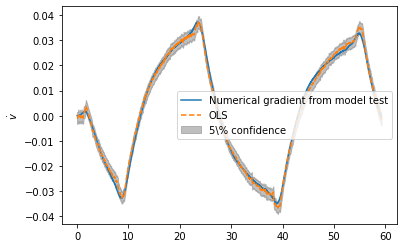

In [278]:
X = diff_eq_Y.calculate_features(data=df, simplify_names=True)
y = diff_eq_Y.calculate_label(y=df['v1d'])
#y+=df['u']*df['r']  # adding centrifugal force

model_Y = sm.OLS(y,X)
results_Y = model_Y.fit()

show_pred(X=X,y=y,results=results_Y, label=r'$\dot{v}$')

In [279]:
X.head()

,Ydelta,Yr,Yu,Yv
time,,,,
0.000000,-0.000007,0.000001,0.932272,0.000830
0.010007,-0.000007,-0.000025,0.921354,0.000791
0.020011,0.000000,-0.000131,0.921396,0.000792
0.030001,0.000000,-0.000191,0.923932,0.000895
0.040001,0.000000,-0.000182,0.924785,0.000876


## X

In [280]:
X_eq = eq.X_eq.copy()
X_eq = X_eq.subs([
    #(eq.p.Xudot,1),  # Removing added mass
    (eq.p.Xvdot,0),  # Removing added mass
    (eq.p.Xrdot,0),  # Removing added mass
    
    #(m,0),  # mass
    
])  

solution = sp.solve(X_eq,u.diff())[0]
X_eq = sp.Eq(u.diff(), solution*(-eq.p.Xudot+m))  # Putting r1d on the LHS

In [281]:
Math(vlatex(X_eq))

<IPython.core.display.Math object>

In [282]:
diff_eq_X = regression.DiffEqToMatrix(ode=X_eq, label=u.diff(), base_features=[delta,u,v,r])

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    u1d   R-squared (uncentered):                   0.230
Model:                            OLS   Adj. R-squared (uncentered):              0.229
Method:                 Least Squares   F-statistic:                              441.7
Date:                Tue, 29 Jun 2021   Prob (F-statistic):                        0.00
Time:                        14:36:28   Log-Likelihood:                          31378.
No. Observations:                5927   AIC:                                 -6.275e+04
Df Residuals:                    5923   BIC:                                 -6.272e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Xdelta         0.0005      0.000      1.214      0.225      -0.000       0.001
Xr            -0.0021      0.004     -0.551      0.582      -0.009       0.005
Xu             0.0006    1.8e-05     35.938      0.000       0.001       0.001
Xv            -0.0045      0.001     -4.802      0.000      -0.006      -0.003
==============================================================================
Omnibus:                       75.201   Durbin-Watson:                   0.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.244
Skew:                           0.143   Prob(JB):                     1.15e-24
Kurtosis:                       3.604   Cond. No.                         223.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

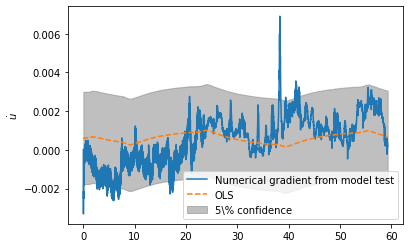

In [283]:
X = diff_eq_X.calculate_features(data=df)
y = diff_eq_X.calculate_label(y=df['u1d'])

model_X = sm.OLS(y,X)
results_X = model_X.fit()

show_pred(X=X,y=y,results=results_X, label=r'$\dot{u}$')

In [284]:
results_summary_X = regression.results_summary_to_dataframe(results_X)
results_summary_Y = regression.results_summary_to_dataframe(results_Y)
results_summary_N = regression.results_summary_to_dataframe(results_N)

## Simulation

In [285]:
eqs = [diff_eq_X.acceleration_equation, diff_eq_Y.acceleration_equation, diff_eq_N.acceleration_equation]
solution = sp.solve(eqs, u.diff(), v.diff(), r.diff(), dict=True)

## Decouple the equations:
u1d_eq = sp.Eq(u.diff(), solution[0][u.diff()]) 
v1d_eq = sp.Eq(v.diff(), solution[0][v.diff()]) 
r1d_eq = sp.Eq(r.diff(), solution[0][r.diff()]) 

## Lambdify:
subs = {value:key for key,value in eq.p.items()}
u1d_lambda = lambdify(u1d_eq.subs(subs).rhs)
v1d_lambda = lambdify(v1d_eq.subs(subs).rhs)
r1d_lambda = lambdify(r1d_eq.subs(subs).rhs)

In [286]:
display(Math(vlatex(u1d_eq)))
display(Math(vlatex(v1d_eq)))
display(Math(vlatex(r1d_eq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [287]:
from scipy.spatial.transform import Rotation as R

def step(t, states, parameters, df_control, meta_data):
    
    u,v,r,x0,y0,psi = states

    states_dict = {
        
        'u':u,
        'v':v,
        'r':r,
        
        'x0':x0,
        'y0':y0,
        'psi':psi,
        
        }
        
    inputs = dict(parameters)
    inputs.update(states_dict)
    
    index = np.argmin(np.array(np.abs(df_control.index - t)))
    control = dict(df_control.iloc[index])
    #print(f't:{t}, i:{index}')
    inputs.update(control)
    
    inputs['U'] = np.sqrt(u**2 + v**2)  #Instantanious velocity
    
    if not 'u1d' in control:
        u1d = -run(function=u1d_lambda, inputs=inputs)
    else:
        u1d = control['u1d']
    
    mass = meta_data['mass']
    v1d = run(function=v1d_lambda, inputs=inputs) - u*r
    #v1d = run(function=v1d_lambda, inputs=inputs)
    
    r1d = run(function=r1d_lambda, inputs=inputs)
    
    
    rotation = R.from_euler('z', psi, degrees=False)
    w = 0
    velocities = rotation.apply([u,v,w])
    x01d = velocities[0]
    y01d = velocities[1]
    psi1d = r    

    dstates = [
        u1d,
        v1d,
        r1d,
        x01d,
        y01d,
        psi1d,
    ]    
    
    #print(t)
    
    return dstates



In [288]:
parameters = dict(results_summary_X['coeff'])  # Fix (-)
parameters.update(dict(results_summary_Y['coeff']))   # Fix (-)
parameters.update(dict(results_summary_N['coeff']))

states = ['u','v','r','x0','y0','psi']
states0 = [float(df[key].iloc[0]) for key in states]
#df_control = df[['delta','u1d','u']]
df_control = df[['delta']].copy()
#df_control['delta']+=np.deg2rad(0.5)

In [289]:
t_ = 10
index = np.argmin(np.array(np.abs(df_control.index - t_)))
df_control.iloc[index]

delta   -0.174529
Name: 10.000023000000002, dtype: float64

In [290]:
(np.diff(df_control.index) > 0).all()

True

In [291]:
## Simulate:
df_ = df.copy()
t = np.array(df_.index)
t_span = [t[0],t[-1]]
solution = solve_ivp(fun=step, t_span=t_span, y0=states0, t_eval=t, args=(parameters, df_control, meta_data), method='RK45')

In [292]:
df_result = pd.DataFrame(data=solution.y.T, columns=states)
df_result.index=t

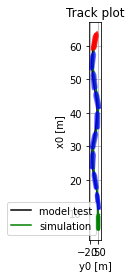

In [293]:
fig,ax=plt.subplots()
#fig.set_size_inches(15,15)
track_plot(df=df_, lpp=meta_data['lpp'], beam=meta_data['beam'], ax=ax, color='k', label='model test');
track_plot(df=df_result, lpp=meta_data['lpp'], beam=meta_data['beam'], ax=ax, color='g', label='simulation');
ax.legend()

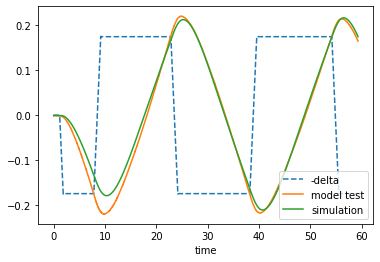

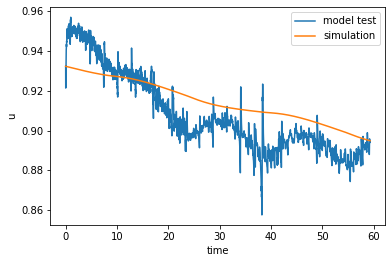

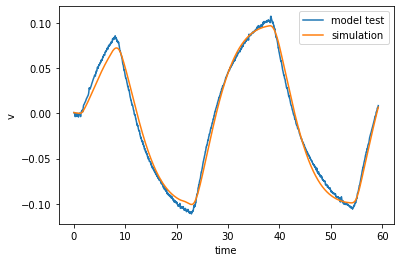

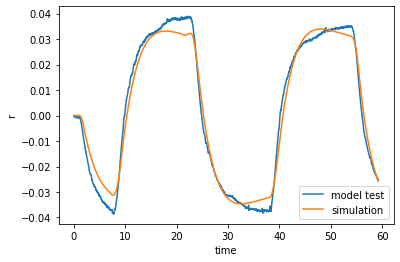

In [294]:
fig,ax=plt.subplots()
df_['-delta'] = -df_['delta']
df_.plot(y='-delta', style='--', ax=ax)
df_.plot(y='psi', ax=ax, label='model test')
df_result.plot(y='psi', ax=ax, label='simulation')
ax.legend()


for key in ['u','v','r']:
    
    fig,ax=plt.subplots()
    df_.plot(y=key, ax=ax, label='model test')
    df_result.plot(y=key, ax=ax, label='simulation')
    ax.set_ylabel(key)
